In [8]:
import numpy as np
import lsst.daf.persistence as dafPersist
from lsst.ip.isr import AssembleCcdTask    # force an import of pcaPsfDeterminer.py (which selects ds9) (DM-13432)
import lsst.afw.cameraGeom.utils as cameraGeomUtils
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt

%matplotlib inline 
#%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

#%matplotlib qt
#%gui qt

In [9]:
afwDisplay.setDefaultBackend("matplotlib" if True else "ds9")


In [10]:
dataPath = "/datasets/comCam/repo/rtm5"

butler = dafPersist.Butler(dataPath)
print("Available runs: %s" % (" ".join(butler.queryMetadata('raw', ['run']))))

Available runs: 4389 4417


In [11]:
camera = butler.get("camera")


In [12]:
butler.queryMetadata('raw', ['visit', 'run'], imageType='FLAT', wavelength=800)


[(269919558, '4389'), (270022788, '4417')]

In [13]:
visit = butler.queryMetadata('raw', ['visit'], imageType='FLAT', wavelength=1000, run=4389)[0]
dataId = dict(visit=visit, ccd='S20')

raw = butler.get('raw', dataId)

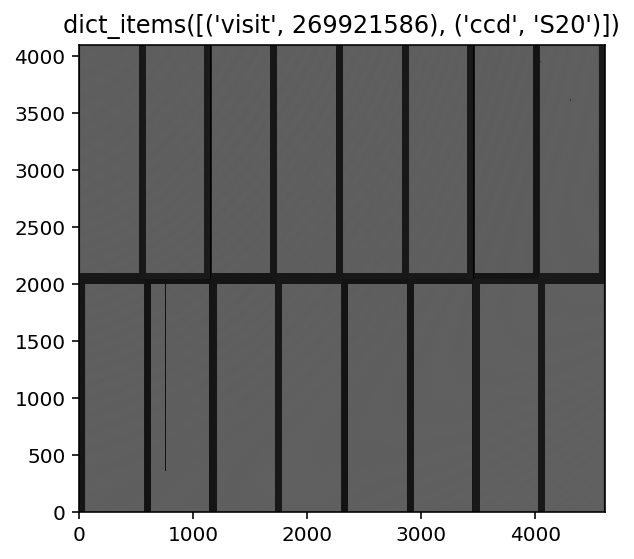

In [14]:
disp = afwDisplay.Display(1)
disp.scale('asinh', 'zscale')

disp.mtv(raw, title=dataId.items())

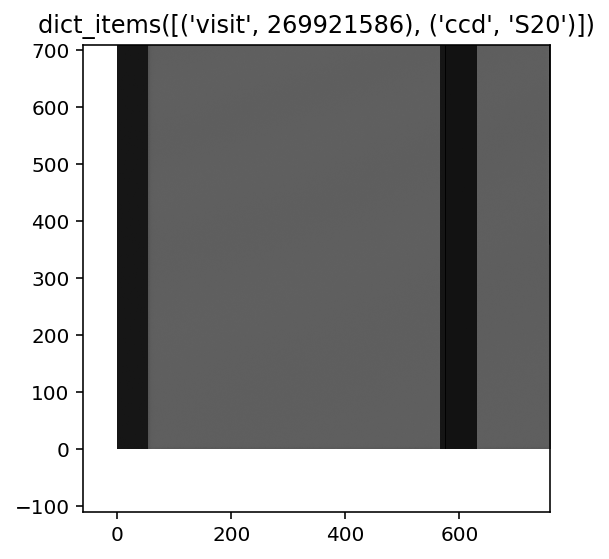

In [33]:
disp = afwDisplay.Display(1)    # you only need this in every cell because I'm using %matplotlib notebook. DM Bug??
disp.scale('asinh', 'zscale')

disp.mtv(raw, title=dataId.items())
#cameraGeomUtils.overlayCcdBoxes(raw.getDetector(), display=disp)

try:
    disp.zoom(10, 350, 300)
except AttributeError as e:
    pass   # bug in display_matplotlib; doesn't work with `inline` in jupyter.  Ticket DM-13475; fixed 2018-02-02

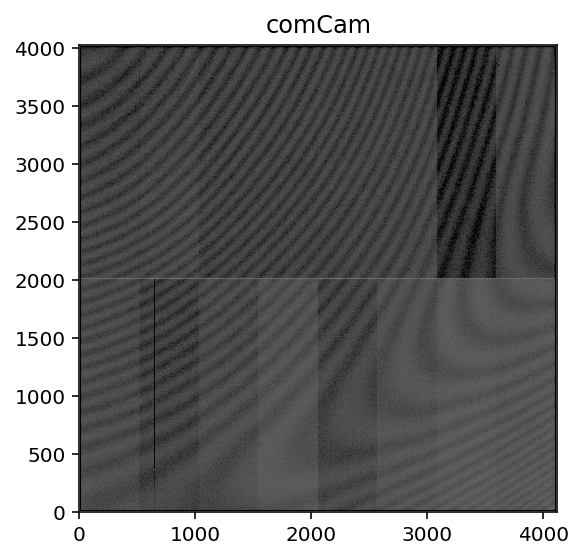

In [17]:
disp = afwDisplay.Display(1)
disp.scale('asinh', 'zscale')

cameraGeomUtils.showCamera(camera,
                           cameraGeomUtils.ButlerImage(butler, "raw", visit=dataId["visit"],
                                                       callback=cameraGeomUtils.rawCallback),
                                 binSize=1, detectorNameList=[dataId["ccd"]], overlay=False, display=disp);

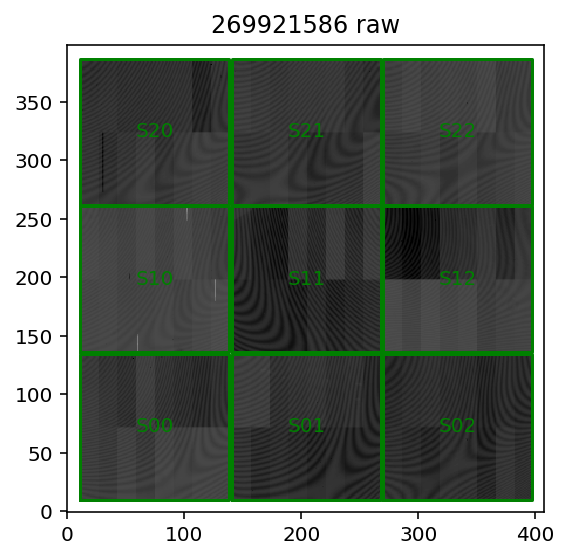

In [18]:
disp = afwDisplay.Display(1)
disp.scale('asinh', 'zscale')

dataType = "raw"
mos = cameraGeomUtils.showCamera(camera,
                                 cameraGeomUtils.ButlerImage(butler, dataType, visit=dataId["visit"],
                                                             callback=cameraGeomUtils.rawCallback),
                                 binSize=32, display=disp, title="%d %s" % (visit, dataType))

In [19]:
def myCallback(im, ccd, imageSource, subtractMedian=True):
    """Assemble the CCD image, subtracting the overscan and subtracting each amp's median"""

    oim = cameraGeomUtils.rawCallback(im, ccd, imageSource,
                                       subtractBias=True, correctGain=False)
    if subtractMedian:
        for a in ccd:
            arr = oim[a.getBBox()].array
            arr -= np.median(arr)

    return oim

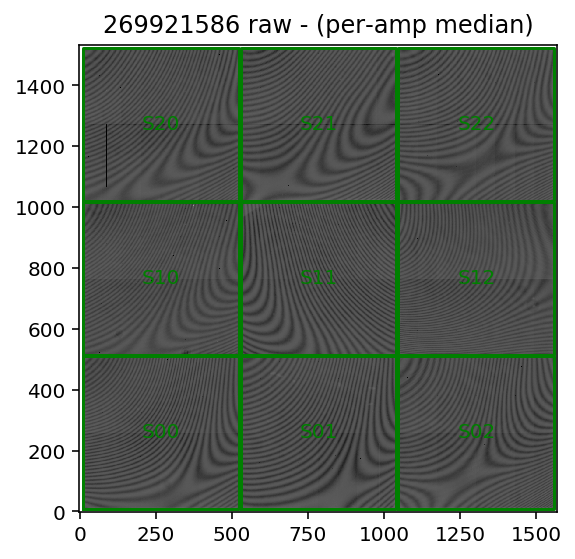

In [31]:
disp = afwDisplay.Display(1)
disp.scale('asinh', 'zscale')

dataType = "raw"
mos = cameraGeomUtils.showCamera(camera,
                                 cameraGeomUtils.ButlerImage(butler, dataType, visit=dataId["visit"],
                                                             callback=myCallback),
                                 binSize=8, display=disp, title="%d %s - (per-amp median)" % (visit, dataType))

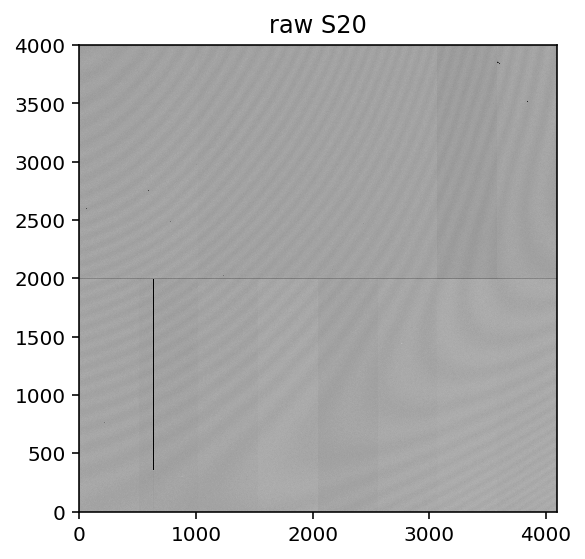

In [27]:
from lsst.ip.isr import AssembleCcdTask

config = AssembleCcdTask.ConfigClass()          # Configuration options
config.doTrim = True

assembleTask = AssembleCcdTask(config=config)   # Build the object that'll do the work -- basically a functor

raw = butler.get('raw', visit=visit, ccd='S20')
exposure = assembleTask.assembleCcd(raw)        # Do the work.

disp = afwDisplay.Display(2)

disp.mtv(exposure, title="raw S20")

In [44]:
disp = afwDisplay.Display(1)
disp.scale('asinh', 'zscale')

dataType = ["bias", "dark", "flat"][0]

mos = cameraGeomUtils.showCamera(camera,
                                 cameraGeomUtils.ButlerImage(butler, dataType, visit=dataId["visit"]),
                                 binSize=32, display=disp, overlay=False, title="%d %s" % (visit, dataType))

UnboundLocalError: local variable 'allowRotate' referenced before assignment

In [25]:
from lsst.ip.isr import IsrTask

config = IsrTask.ConfigClass()
config.doBias = False
config.doDark = False
config.doFringe = False
config.doLinearize = False
config.doDefect = False

isrTask = IsrTask(config=config)

def isrCallback(im, ccd, imageSource, isrTask=isrTask):
    """Run the ISR"""
    dataId = imageSource.kwargs.copy()    # this is the ugly bit
    dataId['ccd'] = ccd.getName()

    if True:   # Avoid re-reading the data by reconstructing the Exposure; this is an ugly bit too
        import lsst.afw.image as afwImage

        raw = afwImage.makeExposure(afwImage.makeMaskedImage(im))
        raw.setDetector(ccd)
        raw.getInfo().setVisitInfo(afwImage.VisitInfo(exposureTime=1.0))
    else:
        raw = butler.get('raw', dataId)

    flat = butler.get('flat', dataId)

    result = isrTask.run(raw, flat=flat)    # Returns a struct;  result.exposure is an Exposure

    return result.exposure.image

In [26]:
disp = afwDisplay.Display(1)
disp.scale('asinh', 'zscale')

mos = cameraGeomUtils.showCamera(camera, 
                                 cameraGeomUtils.ButlerImage(butler, "raw", visit=visit,
                                                             callback=isrCallback), 
                                 binSize=4,
                                 display=disp, title="Post-ISR")

AssertionError: minimum and maximum values must not be equal